In [2]:
import os
import sys

data_path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if data_path not in sys.path:
    sys.path.append(data_path)

print("Final sys.path:", sys.path)

Final sys.path: ['/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/fine_tuning/eval', '/opt/anaconda3/lib/python312.zip', '/opt/anaconda3/lib/python3.12', '/opt/anaconda3/lib/python3.12/lib-dynload', '', '/opt/anaconda3/lib/python3.12/site-packages', '__editable__.lag_llama-0.1.0.finder.__path_hook__', '/opt/anaconda3/lib/python3.12/site-packages/aeosa', '/opt/anaconda3/lib/python3.12/site-packages/setuptools/_vendor', '/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial']


In [3]:
pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /private/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/pip-req-build-seofsras
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /private/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/pip-req-build-seofsras
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 94e20ea7e510ac4d665492b8bed8836a5143f16e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [4]:
from chronos import ChronosPipeline

In [4]:
pip install torchvision


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import numpy as np
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from utils.metrics import calculate_metrics

# Constants
CONTEXT_WINDOW = 378
FORECAST_STEPS = 63
PREDICTION_LENGTH = 1

# Initialize Chronos
pipeline = ChronosPipeline.from_pretrained(
    "./fine_tuned_chronos_4/checkpoint-final/",
    device_map="mps",
    torch_dtype=torch.bfloat16,
)

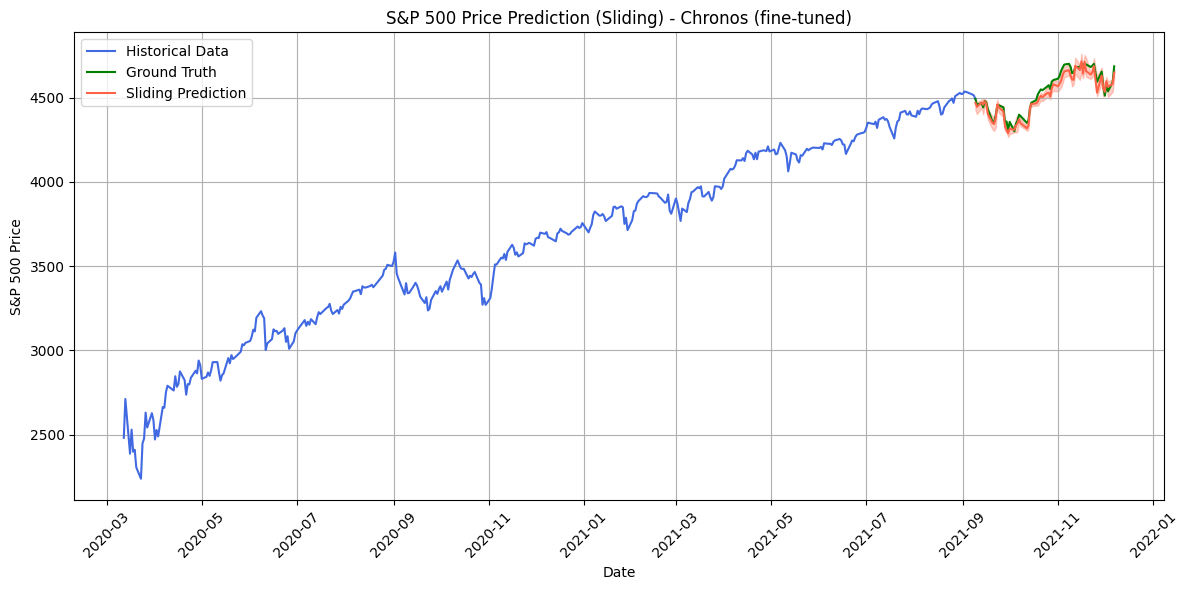


Chronos Sliding Forecast Metrics:
MAE: 43.1636
MSE: 2593.0609
RMSE: 50.9221
Z-NormalizedMAE: 0.3388
Z-NormalizedMSE: 0.1597
Z-NormalizedRMSE: 0.3997
MAPE: 0.9479
SMAPE: 0.9519
MASE: 1.3407
DirectionalAccuracy: 50.9091


In [133]:
import pandas as pd
import numpy as np
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from utils.metrics import calculate_metrics

# Constants
CONTEXT_WINDOW = 378
FORECAST_STEPS = 63
PREDICTION_LENGTH = 1

# Initialize Chronos
pipeline = ChronosPipeline.from_pretrained(
    "./fine_tuned_chronos_4/checkpoint-final/",
    device_map="mps",
    torch_dtype=torch.bfloat16,
)

class TimeSeriesPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        
    def fit_scaler(self, data):
        """Fit scaler on training data"""
        self.scaler.fit(data.reshape(-1, 1))
        
    def generate_single_forecast(self, context_data):
        """Generate single-step forecast with Chronos"""
        # Scale the context data
        context_scaled = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        
        # Convert to tensor and ensure proper shape
        context = torch.tensor(context_scaled, dtype=torch.float32)
        
        # Generate forecast
        with torch.no_grad():
            forecast = pipeline.predict(context, PREDICTION_LENGTH)
        
        # Extract samples and convert back to original scale
        forecast_np = forecast[0].cpu().numpy()  # [num_samples, prediction_length]
        forecast_original = self.scaler.inverse_transform(forecast_np.reshape(-1, 1)).reshape(forecast_np.shape)
        
        # Calculate quantiles
        low = np.quantile(forecast_original, 0.1, axis=0).item()
        median = np.quantile(forecast_original, 0.5, axis=0).item()
        high = np.quantile(forecast_original, 0.9, axis=0).item()
        
        return low, median, high

    def generate_recursive_forecasts(self, data, start_idx):
        """Recursive forecasting implementation"""
        all_forecasts = {
            'median': [], 'low': [], 'high': [], 'dates': []
        }
        
        # Initialize context window
        context_data = data['Close'].iloc[start_idx - CONTEXT_WINDOW:start_idx].to_numpy()
        
        # Fit scaler on context data
        self.fit_scaler(context_data)
        
        # Calculate forecast dates
        forecast_dates = pd.date_range(
            start=data['Date'].iloc[start_idx],
            periods=FORECAST_STEPS,
            freq='D'
        )
        
        for i in range(FORECAST_STEPS):
            # Generate forecast
            low, median, high = self.generate_single_forecast(context_data)
            
            # Store results
            all_forecasts['median'].append(median)
            all_forecasts['low'].append(low)
            all_forecasts['high'].append(high)
            all_forecasts['dates'].append(forecast_dates[i])
            
            # Update context window
            context_data = np.append(context_data[1:], median)
            
        return all_forecasts

    def generate_sliding_window_forecasts(self, data, start_idx):
        """Sliding window implementation"""
        all_forecasts = {
            'median': [], 'low': [], 'high': [], 'dates': []
        }
        
        # Fit scaler on initial context window
        initial_context = data['Close'].iloc[start_idx - CONTEXT_WINDOW:start_idx].to_numpy()
        self.fit_scaler(initial_context)
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = current_idx - CONTEXT_WINDOW
            
            # Get context window
            context_data = data['Close'].iloc[context_start:current_idx].to_numpy()
            
            # Generate forecast
            low, median, high = self.generate_single_forecast(context_data)
            
            # Store results
            all_forecasts['median'].append(median)
            all_forecasts['low'].append(low)
            all_forecasts['high'].append(high)
            all_forecasts['dates'].append(data['Date'].iloc[current_idx])
        
        return all_forecasts

def plot_forecasts(data, start_idx, forecasts, method="recursive"):
    """Visualization for forecasts"""
    plt.figure(figsize=(12, 6))
    
    # Historical context
    context_data = data.iloc[start_idx - CONTEXT_WINDOW:start_idx]
    plt.plot(context_data['Date'], context_data['Close'], 
             color='royalblue', label='Historical Data')
    
    # Actual prices
    actual_data = data.iloc[start_idx - 1:start_idx + FORECAST_STEPS - 1]
    plt.plot(actual_data['Date'], actual_data['Close'], 
             color='green', label='Ground Truth')
    
    # Predictions
    plt.plot(forecasts['dates'], forecasts['median'], 
             color='tomato', label=f'{method.capitalize()} Prediction')
    plt.fill_between(forecasts['dates'], forecasts['low'], forecasts['high'], 
                     color='tomato', alpha=0.3)
    
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.title(f'S&P 500 Price Prediction ({method.capitalize()}) - Chronos (fine-tuned)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def run_experiment(data, target_date, method="recursive"):
    """Run forecasting experiment"""
    predictor = TimeSeriesPredictor()
    target_date = pd.Timestamp(target_date)
    start_idx = data[data['Date'] <= target_date].index[-1]
    
    if start_idx < CONTEXT_WINDOW:
        raise ValueError(f"Need at least {CONTEXT_WINDOW} days of history")
    
    if method.lower() == "recursive":
        forecasts = predictor.generate_recursive_forecasts(data, start_idx)
    else:
        forecasts = predictor.generate_sliding_window_forecasts(data, start_idx)
    
    plot_forecasts(data, start_idx, forecasts, method)
    
    # Calculate metrics
    actual_values = data['Close'].iloc[start_idx:start_idx + FORECAST_STEPS].values
    insample_values = data['Close'].iloc[start_idx - CONTEXT_WINDOW:start_idx].values
    metrics = calculate_metrics(actual_values, np.array(forecasts['median']), insample_values)
    
    print(f"\nChronos {method.capitalize()} Forecast Metrics:")
    for metric_name, value in metrics.items():
        if value is not None:
            print(f"{metric_name}: {value:.4f}")
        else:
            print(f"{metric_name}: None")

from data.snp500 import snp500_daily

sp500_d = snp500_daily
sp500_d['Close'] = snp500_daily['Close']

target_date = '2021-09-09'

run_experiment(sp500_d, target_date, method="sliding")

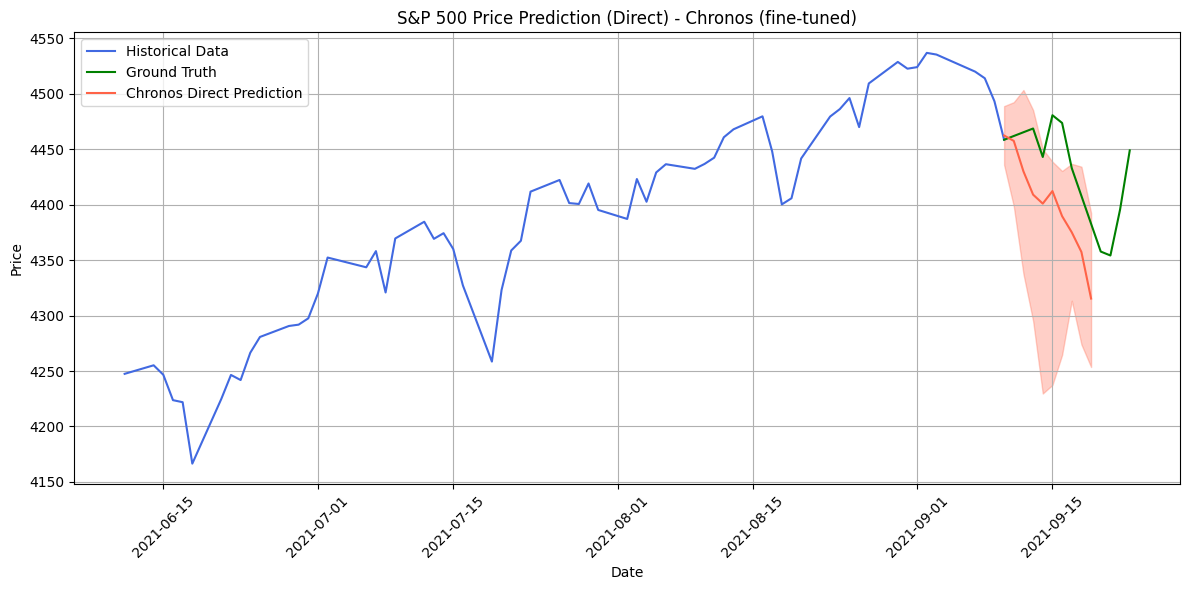


Chronos Direct Forecast Metrics:
MAE: 41.7873
MSE: 3194.8803
RMSE: 56.5233
Z-NormalizedMAE: 0.9470
Z-NormalizedMSE: 1.6408
Z-NormalizedRMSE: 1.2810
MAPE: 0.9409
SMAPE: 0.9482
MASE: nan
DirectionalAccuracy: 37.5000


In [147]:
import pandas as pd
import numpy as np
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from utils.metrics import calculate_metrics

# Constants
CONTEXT_WINDOW = 660
FORECAST_STEPS = 10
PREDICTION_LENGTH = 1

# Initialize Chronos once (large T5 variant)
pipeline = ChronosPipeline.from_pretrained(
    "./fine_tuned_chronos_4/checkpoint-final/",
    device_map="mps",
    torch_dtype=torch.bfloat16,
)

class TimeSeriesPredictor:
    def __init__(self):
        self.scaler = StandardScaler()

    def fit_scaler(self, data):
        """Fit scaler on the given 1D numpy array."""
        self.scaler.fit(data.reshape(-1, 1))
        
    def generate_single_forecast(self, context_data):
        """(Existing) Single-step forecast with Chronos, for reference."""
        # Scale the context
        context_scaled = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        context = torch.tensor(context_scaled, dtype=torch.float32)
        
        with torch.no_grad():
            # Generate single-step forecast
            # Note: Using 'PREDICTION_LENGTH=1' in pipeline.predict
            forecast = pipeline.predict(context, PREDICTION_LENGTH)
        
        forecast_np = forecast[0].cpu().numpy()  # shape: [num_samples, 1]
        forecast_unscaled = self.scaler.inverse_transform(
            forecast_np.reshape(-1, 1)
        ).reshape(forecast_np.shape)
        
        low = np.quantile(forecast_unscaled, 0.1, axis=0).item()
        median = np.quantile(forecast_unscaled, 0.5, axis=0).item()
        high = np.quantile(forecast_unscaled, 0.9, axis=0).item()
        return low, median, high

    def generate_direct_multi_step_forecast(self, context_data, horizon=FORECAST_STEPS):
        """
        Direct multi-step forecast in ONE forward pass.
        - context_data: 1D array of the last CONTEXT_WINDOW points.
        - horizon: number of future steps (128) to predict at once.
        Returns arrays (low_arr, median_arr, high_arr) each of length 'horizon'.
        """
        # Scale the context
        context_scaled = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        context_tensor = torch.tensor(context_scaled, dtype=torch.float32)
        
        with torch.no_grad():
            # Predict 'horizon' steps in one shot
            forecast = pipeline.predict(context_tensor, horizon)
            # forecast[0] shape: (num_samples, horizon)
        
        forecast_np = forecast[0].cpu().numpy()  # shape: [num_samples, horizon]
        
        # Invert scaling
        # Flatten to shape (num_samples * horizon, 1), then reshape back
        forecast_unscaled = self.scaler.inverse_transform(
            forecast_np.reshape(-1, 1)
        ).reshape(forecast_np.shape)
        
        # Compute quantiles across the samples dimension
        low_arr = np.quantile(forecast_unscaled, 0.1, axis=0)
        median_arr = np.quantile(forecast_unscaled, 0.5, axis=0)
        high_arr = np.quantile(forecast_unscaled, 0.9, axis=0)
        
        return low_arr, median_arr, high_arr

    def generate_direct_multi_step_forecasts(self, data, start_idx):
        """
        Generate multi-step forecasts in one pass (no for-loop).
        - data: DataFrame with columns ['Date', 'Close'].
        - start_idx: integer index from which to predict.
        Returns dict with arrays for low, median, high, and corresponding dates.
        """
        all_forecasts = {
            'median': [],
            'low': [],
            'high': [],
            'dates': []
        }
        
        # 1) Extract context window (last CONTEXT_WINDOW points)
        context_data = data['Close'].iloc[start_idx - CONTEXT_WINDOW : start_idx].to_numpy()
        
        # 2) Fit the scaler on that context
        self.fit_scaler(context_data)
        
        # 3) Call direct multi-step forecast
        low_arr, median_arr, high_arr = self.generate_direct_multi_step_forecast(
            context_data, horizon=FORECAST_STEPS
        )
        
        # 4) Build forecast dates
        forecast_dates = pd.date_range(
            start=data['Date'].iloc[start_idx],
            periods=FORECAST_STEPS,
            freq='D'
        )
        
        # 5) Save them in the dictionary
        all_forecasts['low'] = low_arr
        all_forecasts['median'] = median_arr
        all_forecasts['high'] = high_arr
        all_forecasts['dates'] = forecast_dates
        
        return all_forecasts

    # (Existing methods for recursive or sliding-window can remain unchanged)
    # ...

def plot_forecasts(data, start_idx, forecasts, method):
    """Plot the forecasts vs. historical data in the usual style."""
    plt.figure(figsize=(12, 6))
    
    # Historical context
    # context_data = data.iloc[start_idx - CONTEXT_WINDOW:start_idx + 1]
    context_data = data.iloc[start_idx - 63:start_idx + 1]
    plt.plot(context_data['Date'], context_data['Close'],
             color='royalblue', label='Historical Data')
    
    # Actual data
    actual_data = data.iloc[start_idx:start_idx + FORECAST_STEPS]
    plt.plot(actual_data['Date'], actual_data['Close'],
             color='green', label='Ground Truth')
    
    # Forecast data
    plt.plot(forecasts['dates'], forecasts['median'],
             color='tomato', label=f'Chronos {method.capitalize()} Prediction')
    plt.fill_between(forecasts['dates'], forecasts['low'], forecasts['high'],
                     color='tomato', alpha=0.3)
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'S&P 500 Price Prediction ({method.capitalize()}) - Chronos (fine-tuned)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def run_experiment(data, target_date, method="direct"):
    """
    Run a Chronos forecasting experiment:
      - method="direct" to call the one-shot multi-step approach
      - method="recursive" or "sliding" to use the other approaches
    """
    predictor = TimeSeriesPredictor()
    target_date = pd.Timestamp(target_date)
    start_idx = data[data['Date'] <= target_date].index[-1]
    
    if start_idx < CONTEXT_WINDOW:
        raise ValueError(f"Need at least {CONTEXT_WINDOW} days of history")
    
    # Decide how to generate forecasts
    if method.lower() == "direct":
        forecasts = predictor.generate_direct_multi_step_forecasts(data, start_idx)
    elif method.lower() == "recursive":
        forecasts = predictor.generate_recursive_forecasts(data, start_idx)
    else:
        forecasts = predictor.generate_sliding_window_forecasts(data, start_idx)
    
    # Plot
    plot_forecasts(data, start_idx, forecasts, method)
    
    # Evaluate
    actual_values = data['Close'].iloc[start_idx:start_idx + FORECAST_STEPS].values
    metrics = calculate_metrics(actual_values, np.array(forecasts['median']))
    
    print(f"\nChronos {method.capitalize()} Forecast Metrics:")
    for metric_name, value in metrics.items():
        if value is not None:
            print(f"{metric_name}: {value:.4f}")
        else:
            print(f"{metric_name}: None")

run_experiment(sp500_d, "2021-09-09", method="direct")

In [22]:
import yfinance as yf

CONTEXT_WINDOW = 378    # Number of past days used for context
FORECAST_STEPS = 63  # How many days to forecast ahead
PREDICTION_LENGTH = 1  # Prediction horizon per step

# Download TSLA data
nvidia_data = yf.download("NVDA", start="2000-01-01", end="2025-02-10")
nvidia_data.reset_index(inplace=True)
# nvidia_data['Log_Close'] = np.log(nvidia_data['Close'])
# nvidia_data.drop(columns=['Close'], inplace=True)
# nvidia_data.rename(columns={"Log_Close": "Close"}, inplace=True)
nvidia_data['Date'] = pd.to_datetime(nvidia_data['Date'])

# Now you can directly run the existing pipeline with 'nvidia_data'
target_date = "2021-09-09"

def plot_forecasts(data, start_idx, forecasts, method="sliding"):
    """Visualization for forecasts"""
    plt.figure(figsize=(12, 6))
    
    # Historical context
    context_data = data.iloc[start_idx - CONTEXT_WINDOW:start_idx]
    plt.plot(context_data['Date'], context_data['Close'], 
             color='royalblue', label='Historical Data')
    
    # Actual prices
    actual_data = data.iloc[start_idx - 1:start_idx + FORECAST_STEPS - 1]
    plt.plot(actual_data['Date'], actual_data['Close'], 
             color='green', label='Ground Truth')
    
    # Predictions
    plt.plot(forecasts['dates'], forecasts['median'], 
             color='tomato', label=f'{method.capitalize()} Prediction')
    plt.fill_between(forecasts['dates'], forecasts['low'], forecasts['high'], 
                     color='tomato', alpha=0.3)
    
    plt.xlabel('Date')
    plt.ylabel('NVIDIA Adj Closing Price')
    plt.title(f'NVIDIA Adj Closing Price Prediction ({method.capitalize()}) - Chronos')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

run_experiment(nvidia_data, target_date, method="sliding")

[*********************100%***********************]  1 of 1 completed


AttributeError: 'TimeSeriesPredictor' object has no attribute 'generate_sliding_window_forecasts'

In [30]:
pip install "chronos-forecasting[evaluation] @ git+https://github.com/amazon-science/chronos-forecasting.git"

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /private/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/pip-install-un8irpzu/chronos-forecasting_35e92d5b73f74dc89b4bc639d34f261d
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /private/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/pip-install-un8irpzu/chronos-forecasting_35e92d5b73f74dc89b4bc639d34f261d
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 8178798f4e1183cb88bf6fdbfaf8c92387805116
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [31]:
!git clone https://github.com/amazon-science/chronos-forecasting.git

Cloning into 'chronos-forecasting'...
remote: Enumerating objects: 458, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 458 (delta 0), reused 0 (delta 0), pack-reused 457 (from 2)
Receiving objects: 100% (458/458), 1017.31 KiB | 6.20 MiB/s, done.
Resolving deltas: 100% (195/195), done.


In [32]:
cd chronos-forecasting

/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/fine_tuning/eval/chronos-forecasting


In [40]:
!python scripts/evaluation/evaluate.py scripts/evaluation/configs/in-domain.yaml \
   --chronos-model-id "/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/fine_tuning/eval/fine_tuned_chronos/checkpoint-27330" \
   --batch-size 32 \
   --device mps \
   --num-samples 20 \
   evaluation/results/metrics.json


2025-02-15 01:10:10,544 - Chronos Evaluation - INFO - Loading electricity_15min
Generating train split: 100%|█████████| 370/370 [00:00<00:00, 515.22 examples/s]
2025-02-15 01:10:47,820 - Chronos Evaluation - INFO - Generating forecasts for electricity_15min (370 time series)
12it [02:13, 11.11s/it]
2025-02-15 01:13:01,099 - Chronos Evaluation - INFO - Evaluating forecasts for electricity_15min
370it [00:05, 66.35it/s]
2025-02-15 01:13:06,683 - Chronos Evaluation - INFO - Loading monash_electricity_hourly
Generating train split: 100%|████████| 321/321 [00:00<00:00, 1897.35 examples/s]
2025-02-15 01:13:12,703 - Chronos Evaluation - INFO - Generating forecasts for monash_electricity_hourly (321 time series)
0it [00:00, ?it/s]^C



Trial 0
Global scaling metrics: {'MAE': 38.713657924107146, 'MSE': 2060.1635783267398, 'RMSE': 45.38902486644475, 'Z-NormalizedMAE': 0.38284983830364, 'Z-NormalizedMSE': 0.2014792030928058, 'Z-NormalizedRMSE': 0.44886434820868293, 'MAPE': 0.9740718960128246, 'SMAPE': 0.9744430735042096, 'MASE': 0.9371059052708263, 'DirectionalAccuracy': 44.0}
Context scaling metrics: {'MAE': 35.311474996899804, 'MSE': 1805.9165712337171, 'RMSE': 42.49607712758576, 'Z-NormalizedMAE': 0.34920473077817293, 'Z-NormalizedMSE': 0.17661443753887907, 'Z-NormalizedRMSE': 0.42025520524899995, 'MAPE': 0.8883555664604016, 'SMAPE': 0.887089361490187, 'MASE': 0.8547523927676257, 'DirectionalAccuracy': 43.13725490196079}

Trial 1
Global scaling metrics: {'MAE': 38.21844385540675, 'MSE': 2063.133012262602, 'RMSE': 45.42172401244367, 'Z-NormalizedMAE': 0.37795253238387116, 'Z-NormalizedMSE': 0.20176960682061082, 'Z-NormalizedRMSE': 0.44918771891115944, 'MAPE': 0.9618538897092519, 'SMAPE': 0.962139609326941, 'MASE': 0.

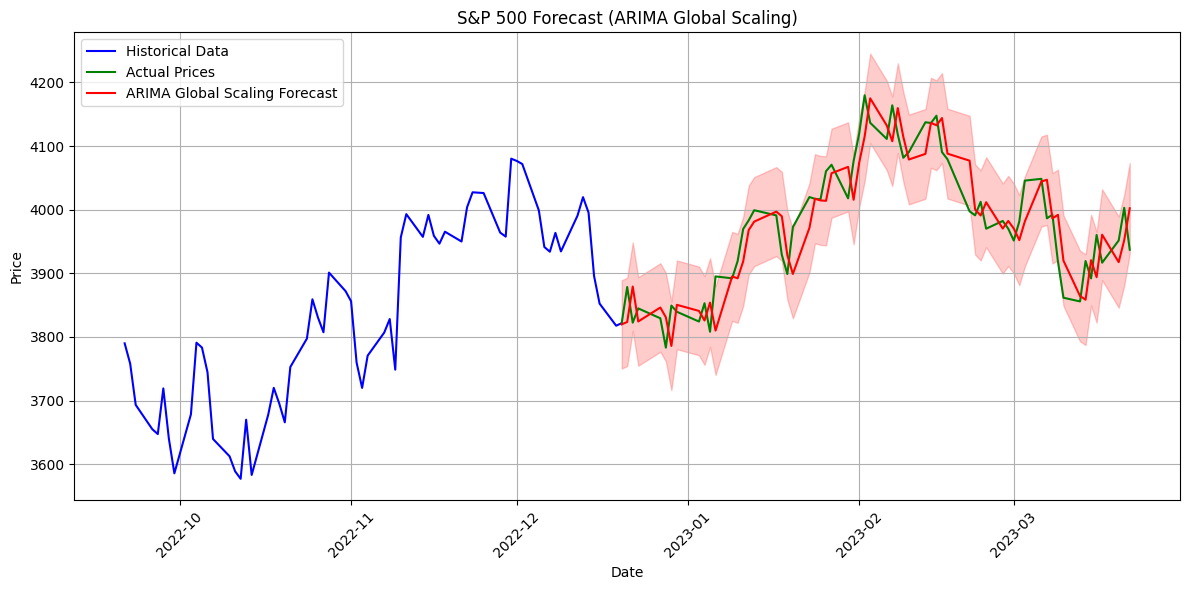

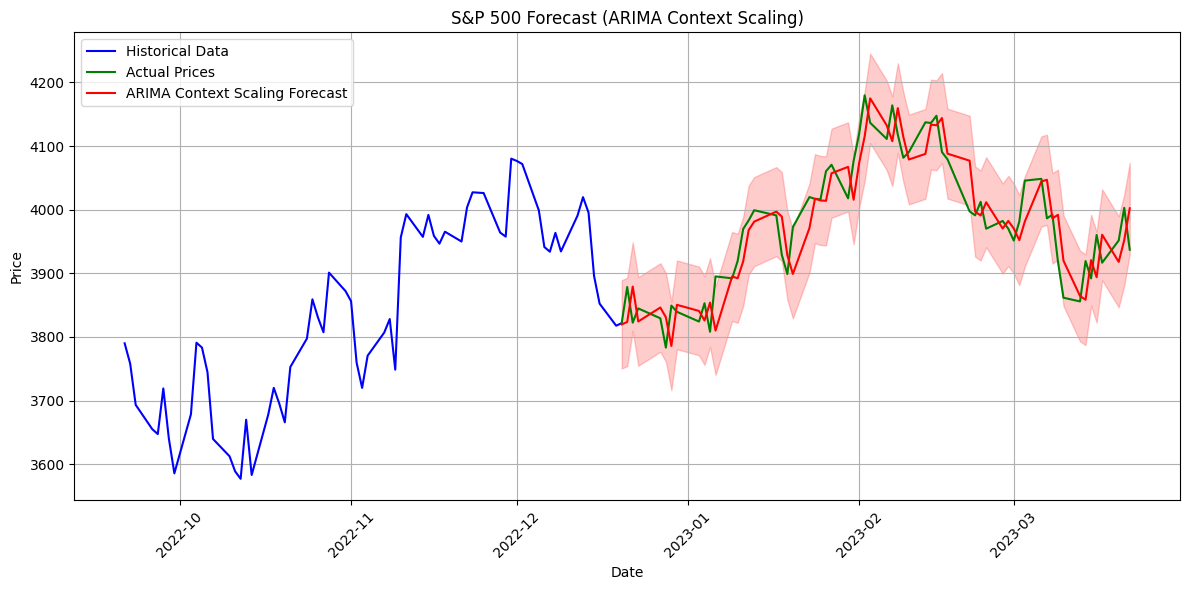

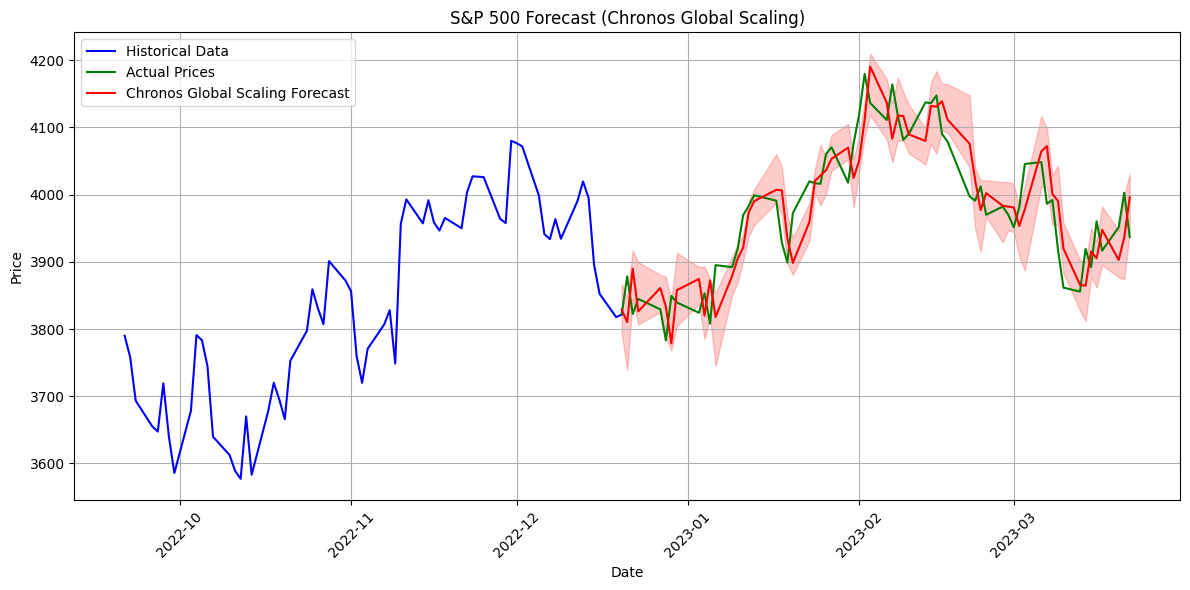

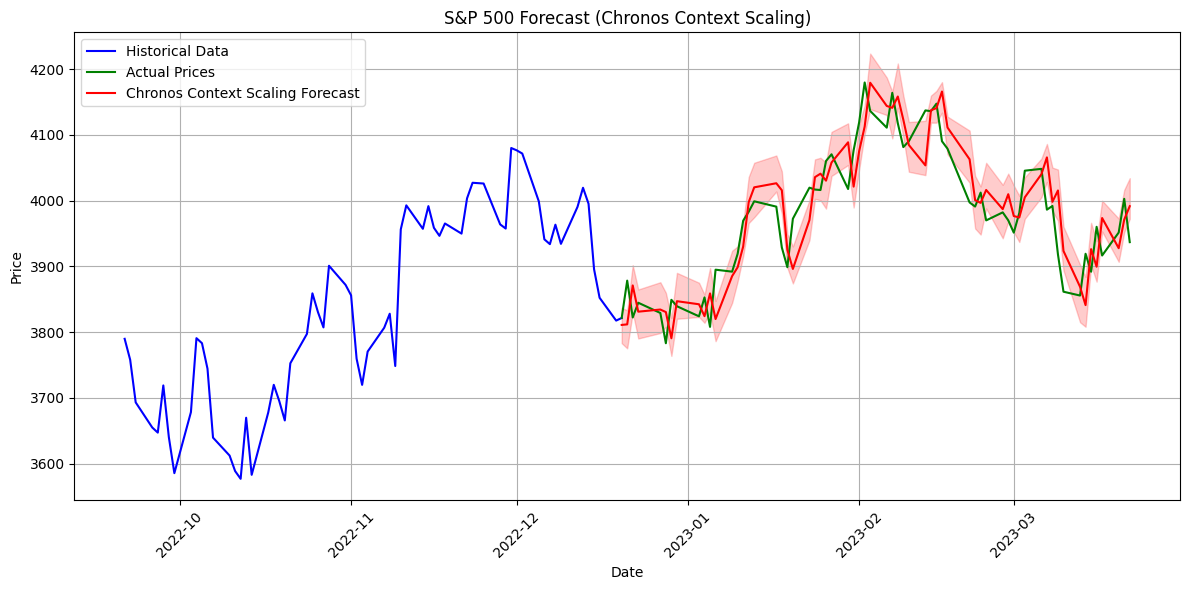

In [11]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from chronos import ChronosPipeline
from sklearn.preprocessing import StandardScaler

from utils.metrics import calculate_metrics
from data.snp500 import snp500_daily   

# Updated Constants
CONTEXT_WINDOW = 378
FORECAST_STEPS = 63
CONFIDENCE_ALPHA = 0.2
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1

# ======================
# Data Preparation
# ======================
def prepare_data(data):
    """Split data into indices for train/val/test sets"""
    n = len(data)
    train_end = int(TRAIN_RATIO * n)
    val_end = train_end + int(VAL_RATIO * n)
    return train_end, val_end

# ======================
# ARIMA Implementation (Fixed Scaling)
# ======================
class ARIMAPredictor:
    def __init__(self, train_data):
        self.scaler = StandardScaler()
        self.scaler.fit(train_data.reshape(-1, 1))  # Fit once on training data
        
    def generate_single_forecast(self, context_data):
        """ARIMA(1,1,1) one-step forecast"""
        try:
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            
            model = ARIMA(scaled_data, order=(1,1,1))
            model_fit = model.fit()
            forecast = model_fit.get_forecast(steps=1)
            
            median = self.scaler.inverse_transform([forecast.predicted_mean])[0][0]
            ci = self.scaler.inverse_transform(forecast.conf_int(alpha=CONFIDENCE_ALPHA))
            return ci[0][0], median, ci[0][1]
        except Exception as e:
            raise e
    
    def expanding_window_forecast(self, full_data, start_idx):
        """Forecast with expanding window using fixed scaling"""
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            # Ensure we have at least 2 samples for differencing
            if len(context_data) < 2:
                raise ValueError(f"Insufficient context data (need ≥2 samples, got {len(context_data)})")
            
            low, median, high = self.generate_single_forecast(context_data)
            
            # Fix date alignment
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Chronos Implementation (Fixed Scaling)
# ======================
class ChronosPredictor:
    def __init__(self, train_data):
        self.scaler = StandardScaler()
        self.scaler.fit(train_data.reshape(-1, 1))
        self.pipeline = ChronosPipeline.from_pretrained(
            "./ft_chronos_sp500_closing_rk2/checkpoint-final/",
            device_map="mps",
            torch_dtype=torch.bfloat16,
        )
        
    def generate_single_forecast(self, context_data):
        try:
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            context = torch.tensor(scaled_data, dtype=torch.bfloat16)
            
            forecast = self.pipeline.predict(context, 1)
            forecast_np = forecast[0].cpu().numpy()
            
            forecast_original = self.scaler.inverse_transform(forecast_np.reshape(-1, 1))
            return (
                np.quantile(forecast_original, 0.1).item(),
                np.quantile(forecast_original, 0.5).item(),
                np.quantile(forecast_original, 0.9).item()
            )
        except Exception as e:
            print(f"Chronos error: {str(e)}")
            last_val = self.scaler.inverse_transform([[context_data[-1]]])[0][0]
            return last_val*0.99, last_val, last_val*1.01

    def sliding_window_forecast(self, full_data, start_idx):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < CONTEXT_WINDOW:
                raise ValueError(f"Need at least {CONTEXT_WINDOW} samples for context")
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# ARIMA Implementation with Context Window Scaling
# ======================
class ARIMAPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        
    def generate_single_forecast(self, context_data):
        """ARIMA(1,1,1) one-step forecast with context window scaling"""
        try:
            # Fit scaler on context window
            self.scaler.fit(context_data.reshape(-1, 1))
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            
            model = ARIMA(scaled_data, order=(1,1,1))
            model_fit = model.fit()
            forecast = model_fit.get_forecast(steps=1)
            
            median = self.scaler.inverse_transform([forecast.predicted_mean])[0][0]
            ci = self.scaler.inverse_transform(forecast.conf_int(alpha=CONFIDENCE_ALPHA))
            return ci[0][0], median, ci[0][1]
        except Exception as e:
            raise e
    
    def expanding_window_forecast(self, full_data, start_idx):
        """Forecast with expanding window using context window scaling"""
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < 2:
                raise ValueError(f"Insufficient context data (need ≥2 samples, got {len(context_data)})")
            
            low, median, high = self.generate_single_forecast(context_data)
            
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Chronos Implementation with Context Window Scaling
# ======================
class ChronosPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pipeline = ChronosPipeline.from_pretrained(
            "./ft_chronos_sp500_closing_rk2/checkpoint-final/",
            device_map="mps",
            torch_dtype=torch.bfloat16,
        )
        
    def generate_single_forecast(self, context_data):
        try:
            # Fit scaler on context window
            self.scaler.fit(context_data.reshape(-1, 1))
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            context = torch.tensor(scaled_data, dtype=torch.bfloat16)
            
            forecast = self.pipeline.predict(context, 1)
            forecast_np = forecast[0].cpu().numpy()
            
            forecast_original = self.scaler.inverse_transform(forecast_np.reshape(-1, 1))
            return (
                np.quantile(forecast_original, 0.1).item(),
                np.quantile(forecast_original, 0.5).item(),
                np.quantile(forecast_original, 0.9).item()
            )
        except Exception as e:
            print(f"Chronos error: {str(e)}")
            last_val = context_data[-1]
            return last_val*0.99, last_val, last_val*1.01

    def sliding_window_forecast(self, full_data, start_idx):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < CONTEXT_WINDOW:
                raise ValueError(f"Need at least {CONTEXT_WINDOW} samples for context")
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

def run_multiple_trials_comparison(full_data, train_end, val_end, n_trials=1, test_start=None):
    """Run trials for both global and context scaling approaches"""
    train_data = full_data['Close'].iloc[:train_end].values
    test_start = val_end
    actual = full_data['Close'].iloc[test_start:test_start+FORECAST_STEPS].values
    
    # Global scaling ARIMA
    arima_global = ARIMAPredictor(train_data)
    insample_data = full_data['Close'].iloc[test_start - CONTEXT_WINDOW:test_start].values
    arima_global_preds = arima_global.expanding_window_forecast(full_data, test_start)
    arima_global_metrics = calculate_metrics(actual, arima_global_preds['median'], insample=insample_data)
    
    # Context window scaling ARIMA
    arima_context = ARIMAPredictorContextScale()
    arima_context_preds = arima_context.expanding_window_forecast(full_data, test_start)
    arima_context_metrics = calculate_metrics(actual, arima_context_preds['median'], insample=insample_data)
    
    # Global scaling Chronos
    chronos_global = ChronosPredictor(train_data)
    chronos_global_metrics_list = []
    chronos_global_preds = None
    
    # Context window scaling Chronos
    chronos_context = ChronosPredictorContextScale()
    chronos_context_metrics_list = []
    chronos_context_preds = None
    
    for trial in range(n_trials):
        # Global scaling trial
        chronos_global_preds = chronos_global.sliding_window_forecast(full_data, test_start)
        chronos_global_metrics = calculate_metrics(actual, chronos_global_preds['median'], insample=insample_data)
        chronos_global_metrics_list.append(chronos_global_metrics)
        
        # Context window scaling trial
        chronos_context_preds = chronos_context.sliding_window_forecast(full_data, test_start)
        chronos_context_metrics = calculate_metrics(actual, chronos_context_preds['median'], insample=insample_data)
        chronos_context_metrics_list.append(chronos_context_metrics)
        
        print(f"\nTrial {trial}")
        print("Global scaling metrics:", chronos_global_metrics)
        print("Context scaling metrics:", chronos_context_metrics)
    
    # Calculate statistics for Chronos
    chronos_global_avg = {metric: np.mean([m[metric] for m in chronos_global_metrics_list]) 
                         for metric in chronos_global_metrics_list[0]}
    chronos_global_std = {metric: np.std([m[metric] for m in chronos_global_metrics_list]) 
                         for metric in chronos_global_metrics_list[0]}
    
    chronos_context_avg = {metric: np.mean([m[metric] for m in chronos_context_metrics_list]) 
                          for metric in chronos_context_metrics_list[0]}
    chronos_context_std = {metric: np.std([m[metric] for m in chronos_context_metrics_list]) 
                          for metric in chronos_context_metrics_list[0]}
    
    return (arima_global_metrics, arima_context_metrics, 
            chronos_global_avg, chronos_global_std,
            chronos_context_avg, chronos_context_std,
            arima_global_preds, arima_context_preds,
            chronos_global_preds, chronos_context_preds)


def plot_individual_forecast(data, start_idx, forecasts, model_name):
    """Fixed plotting function with proper index alignment"""
    plt.figure(figsize=(12, 6))
    
    # Historical data (3 months before forecast start)
    historical_start = max(0, start_idx - 63)
    historical = data.iloc[historical_start:start_idx + 1]
    plt.plot(historical['Date'], historical['Close'], 'b-', label='Historical Data')
    
    # Actual values with CORRECTED indices
    actual_dates = data['Date'].iloc[start_idx:start_idx+FORECAST_STEPS]
    actual_values = data['Close'].iloc[start_idx:start_idx+FORECAST_STEPS]
    plt.plot(actual_dates, actual_values, 'g-', label='Actual Prices')
    
    # Forecasts with alignment validation
    forecast_dates = forecasts['dates']
    if len(forecast_dates) != FORECAST_STEPS:
        raise ValueError(f"Expected {FORECAST_STEPS} forecast dates, got {len(forecast_dates)}")
    
    # if model_name == "ARIMA Global Scaling" or "ARIMA Context Scaling":
    #     plt.plot(forecast_dates, forecasts['median'], 'r-', label=f'{model_name} Forecast')
    # else:     
    plt.plot(forecast_dates, forecasts['median'], 'r-', label=f'{model_name} Forecast')
    plt.fill_between(forecast_dates, forecasts['low'], forecasts['high'], color='red', alpha=0.2)
    
    plt.title(f'S&P 500 Forecast ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def main():
    data = snp500_daily.sort_values('Date')
    train_end, val_end = prepare_data(data)
    test_start = val_end
    
    results = run_multiple_trials_comparison(data, train_end, val_end, 10, test_start)
    (arima_global_metrics, arima_context_metrics, 
     chronos_global_avg, chronos_global_std,
     chronos_context_avg, chronos_context_std,
     arima_global_preds, arima_context_preds,
     chronos_global_preds, chronos_context_preds) = results
    
    # Print results
    print("\nARIMA Global Scaling Metrics:")
    for metric, value in arima_global_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nARIMA Context Window Scaling Metrics:")
    for metric, value in arima_context_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nChronos Global Scaling Metrics (Average ± Std):")
    for metric in chronos_global_avg:
        print(f"{metric}: {chronos_global_avg[metric]:.4f} ± {chronos_global_std[metric]:.4f}")
    
    print("\nChronos Context Window Scaling Metrics (Average ± Std):")
    for metric in chronos_context_avg:
        print(f"{metric}: {chronos_context_avg[metric]:.4f} ± {chronos_context_std[metric]:.4f}")
    
    # Plot results
    plot_individual_forecast(data, test_start, arima_global_preds, "ARIMA Global Scaling")
    plot_individual_forecast(data, test_start, arima_context_preds, "ARIMA Context Scaling")
    plot_individual_forecast(data, test_start, chronos_global_preds, "Chronos Global Scaling")
    plot_individual_forecast(data, test_start, chronos_context_preds, "Chronos Context Scaling")

if __name__ == "__main__":
    main()


Trial 0
Global scaling metrics: {'MAE': 0.016163021634244202, 'MSE': 0.00036319660895388096, 'RMSE': 0.019057717831731085, 'Z-NormalizedMAE': 1.4968699252506181, 'Z-NormalizedMSE': 3.115048422321469, 'Z-NormalizedRMSE': 1.7649499772858916, 'MAPE': 628.5234455242323, 'SMAPE': 136.08880122292376, 'MASE': 1.1560141921439928, 'DirectionalAccuracy': 43.54838709677419}
Context scaling metrics: {'MAE': 0.009151279253328676, 'MSE': 0.0001187976140114801, 'RMSE': 0.010899431820580377, 'Z-NormalizedMAE': 0.8475070442803482, 'Z-NormalizedMSE': 1.0188980595603703, 'Z-NormalizedRMSE': 1.0094048046053528, 'MAPE': 139.31020885455095, 'SMAPE': 158.47003775832218, 'MASE': 0.6545192435248209, 'DirectionalAccuracy': 53.2258064516129}

Trial 1
Global scaling metrics: {'MAE': 0.015975580658872654, 'MSE': 0.00035619783125366745, 'RMSE': 0.01887320405372833, 'Z-NormalizedMAE': 1.4795108716564025, 'Z-NormalizedMSE': 3.0550216189434756, 'Z-NormalizedRMSE': 1.7478620137023047, 'MAPE': 629.3925046236998, 'SMAPE

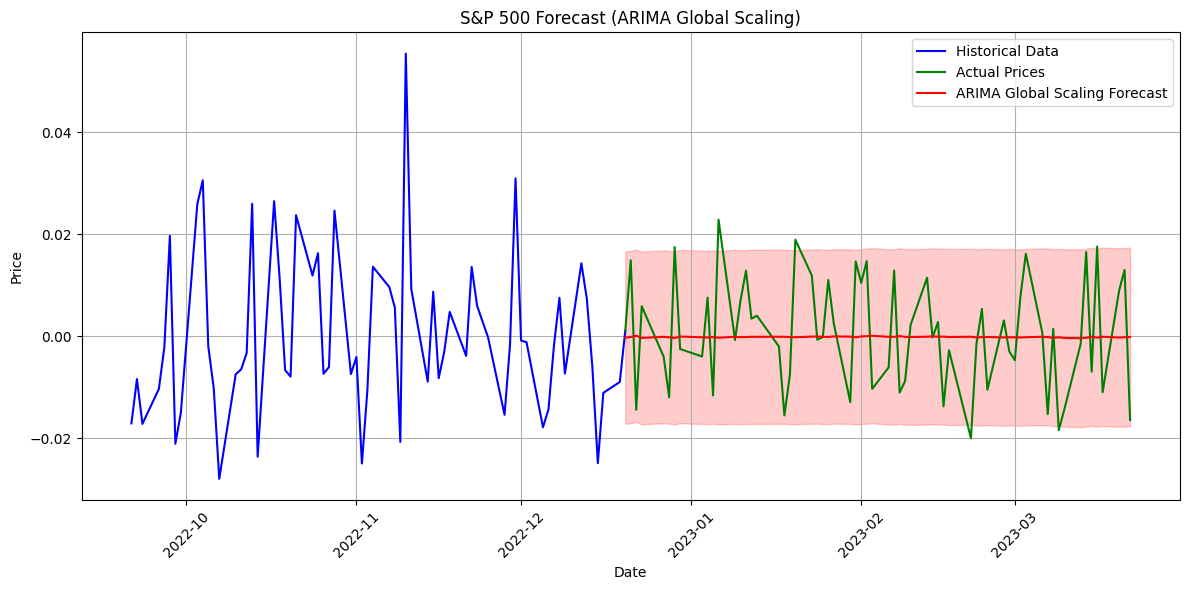

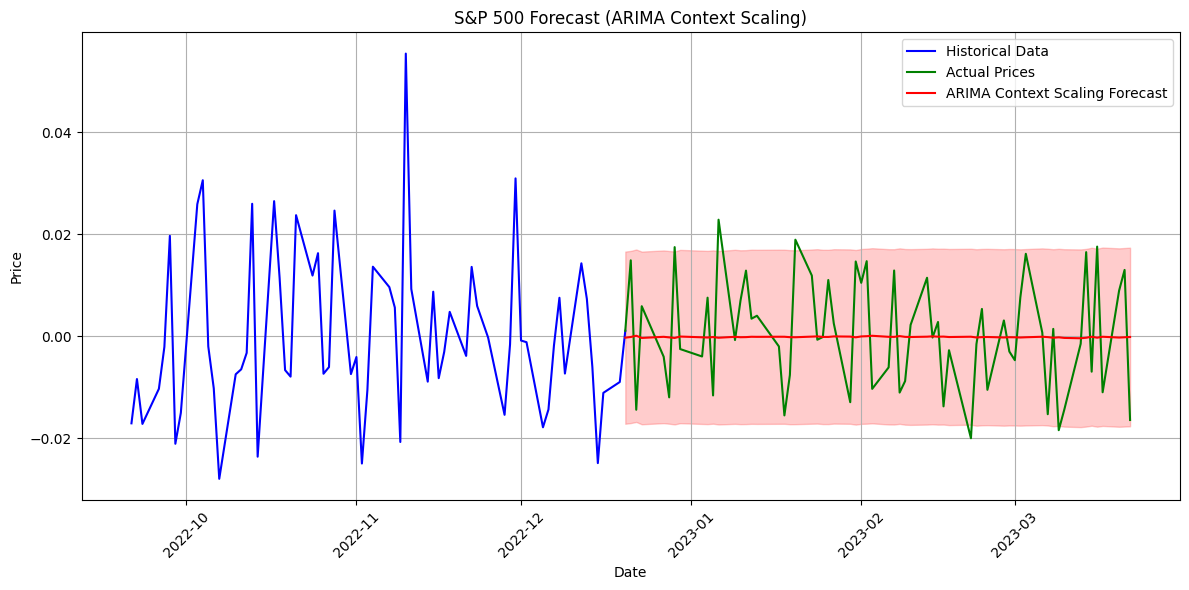

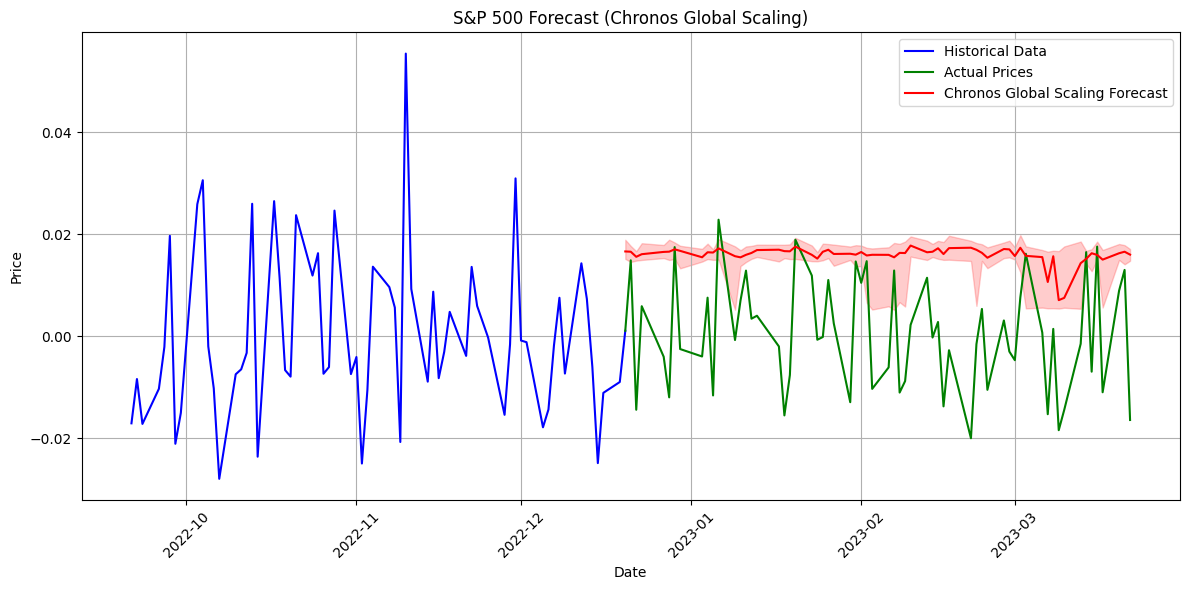

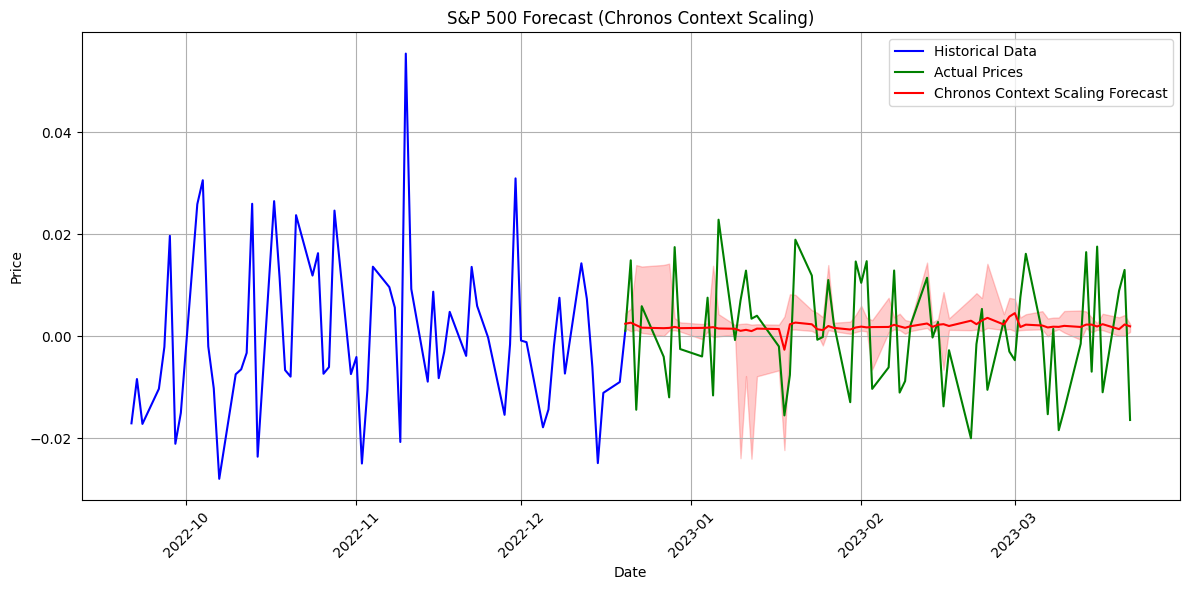

In [10]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from chronos import ChronosPipeline
from sklearn.preprocessing import StandardScaler

from utils.metrics import calculate_metrics
from data.snp500 import snp500_daily   

# Updated Constants
CONTEXT_WINDOW = 378
FORECAST_STEPS = 63
CONFIDENCE_ALPHA = 0.2
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1

# ======================
# Data Preparation
# ======================
def prepare_data(data):
    """Split data into indices for train/val/test sets"""
    n = len(data)
    train_end = int(TRAIN_RATIO * n)
    val_end = train_end + int(VAL_RATIO * n)
    return train_end, val_end

# ======================
# ARIMA Implementation (Fixed Scaling)
# ======================
class ARIMAPredictor:
    def __init__(self, train_data):
        self.scaler = StandardScaler()
        self.scaler.fit(train_data.reshape(-1, 1))  # Fit once on training data
        
    def generate_single_forecast(self, context_data):
        """ARIMA(1,1,1) one-step forecast"""
        try:
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            
            model = ARIMA(scaled_data, order=(1,1,1))
            model_fit = model.fit()
            forecast = model_fit.get_forecast(steps=1)
            
            median = self.scaler.inverse_transform([forecast.predicted_mean])[0][0]
            ci = self.scaler.inverse_transform(forecast.conf_int(alpha=CONFIDENCE_ALPHA))
            return ci[0][0], median, ci[0][1]
        except Exception as e:
            raise e
    
    def expanding_window_forecast(self, full_data, start_idx):
        """Forecast with expanding window using fixed scaling"""
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Return'].iloc[context_start:current_idx].values
            
            # Ensure we have at least 2 samples for differencing
            if len(context_data) < 2:
                raise ValueError(f"Insufficient context data (need ≥2 samples, got {len(context_data)})")
            
            low, median, high = self.generate_single_forecast(context_data)
            
            # Fix date alignment
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Chronos Implementation (Fixed Scaling)
# ======================
class ChronosPredictor:
    def __init__(self, train_data):
        self.scaler = StandardScaler()
        self.scaler.fit(train_data.reshape(-1, 1))
        self.pipeline = ChronosPipeline.from_pretrained(
            "./fine_tuned_chronos_sp500/checkpoint-final/",
            device_map="mps",
            torch_dtype=torch.bfloat16,
        )
        
    def generate_single_forecast(self, context_data):
        try:
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            context = torch.tensor(scaled_data, dtype=torch.bfloat16)
            
            forecast = self.pipeline.predict(context, 1)
            forecast_np = forecast[0].cpu().numpy()
            
            forecast_original = self.scaler.inverse_transform(forecast_np.reshape(-1, 1))
            return (
                np.quantile(forecast_original, 0.1).item(),
                np.quantile(forecast_original, 0.5).item(),
                np.quantile(forecast_original, 0.9).item()
            )
        except Exception as e:
            print(f"Chronos error: {str(e)}")
            last_val = self.scaler.inverse_transform([[context_data[-1]]])[0][0]
            return last_val*0.99, last_val, last_val*1.01

    def sliding_window_forecast(self, full_data, start_idx):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Return'].iloc[context_start:current_idx].values
            
            if len(context_data) < CONTEXT_WINDOW:
                raise ValueError(f"Need at least {CONTEXT_WINDOW} samples for context")
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# ARIMA Implementation with Context Window Scaling
# ======================
class ARIMAPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        
    def generate_single_forecast(self, context_data):
        """ARIMA(1,1,1) one-step forecast with context window scaling"""
        try:
            # Fit scaler on context window
            self.scaler.fit(context_data.reshape(-1, 1))
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            
            model = ARIMA(scaled_data, order=(1,1,1))
            model_fit = model.fit()
            forecast = model_fit.get_forecast(steps=1)
            
            median = self.scaler.inverse_transform([forecast.predicted_mean])[0][0]
            ci = self.scaler.inverse_transform(forecast.conf_int(alpha=CONFIDENCE_ALPHA))
            return ci[0][0], median, ci[0][1]
        except Exception as e:
            raise e
    
    def expanding_window_forecast(self, full_data, start_idx):
        """Forecast with expanding window using context window scaling"""
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Return'].iloc[context_start:current_idx].values
            
            if len(context_data) < 2:
                raise ValueError(f"Insufficient context data (need ≥2 samples, got {len(context_data)})")
            
            low, median, high = self.generate_single_forecast(context_data)
            
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Chronos Implementation with Context Window Scaling
# ======================
class ChronosPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pipeline = ChronosPipeline.from_pretrained(
            "./fine_tuned_chronos_1/checkpoint-final/",
            device_map="mps",
            torch_dtype=torch.bfloat16,
        )
        
    def generate_single_forecast(self, context_data):
        try:
            # Fit scaler on context window
            self.scaler.fit(context_data.reshape(-1, 1))
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            context = torch.tensor(scaled_data, dtype=torch.bfloat16)
            
            forecast = self.pipeline.predict(context, 1)
            forecast_np = forecast[0].cpu().numpy()
            
            forecast_original = self.scaler.inverse_transform(forecast_np.reshape(-1, 1))
            return (
                np.quantile(forecast_original, 0.1).item(),
                np.quantile(forecast_original, 0.5).item(),
                np.quantile(forecast_original, 0.9).item()
            )
        except Exception as e:
            print(f"Chronos error: {str(e)}")
            last_val = context_data[-1]
            return last_val*0.99, last_val, last_val*1.01

    def sliding_window_forecast(self, full_data, start_idx):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Return'].iloc[context_start:current_idx].values
            
            if len(context_data) < CONTEXT_WINDOW:
                raise ValueError(f"Need at least {CONTEXT_WINDOW} samples for context")
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

def run_multiple_trials_comparison(full_data, train_end, val_end, n_trials=1, test_start=None):
    """Run trials for both global and context scaling approaches"""
    train_data = full_data['Return'].iloc[:train_end].values
    test_start = val_end
    actual = full_data['Return'].iloc[test_start:test_start+FORECAST_STEPS].values
    
    # Global scaling ARIMA
    arima_global = ARIMAPredictor(train_data)
    insample_data = full_data['Return'].iloc[test_start - CONTEXT_WINDOW:test_start].values
    arima_global_preds = arima_global.expanding_window_forecast(full_data, test_start)
    arima_global_metrics = calculate_metrics(actual, arima_global_preds['median'], insample=insample_data)
    
    # Context window scaling ARIMA
    arima_context = ARIMAPredictorContextScale()
    arima_context_preds = arima_context.expanding_window_forecast(full_data, test_start)
    arima_context_metrics = calculate_metrics(actual, arima_context_preds['median'], insample=insample_data)
    
    # Global scaling Chronos
    chronos_global = ChronosPredictor(train_data)
    chronos_global_metrics_list = []
    chronos_global_preds = None
    
    # Context window scaling Chronos
    chronos_context = ChronosPredictorContextScale()
    chronos_context_metrics_list = []
    chronos_context_preds = None
    
    for trial in range(n_trials):
        # Global scaling trial
        chronos_global_preds = chronos_global.sliding_window_forecast(full_data, test_start)
        chronos_global_metrics = calculate_metrics(actual, chronos_global_preds['median'], insample=insample_data)
        chronos_global_metrics_list.append(chronos_global_metrics)
        
        # Context window scaling trial
        chronos_context_preds = chronos_context.sliding_window_forecast(full_data, test_start)
        chronos_context_metrics = calculate_metrics(actual, chronos_context_preds['median'], insample=insample_data)
        chronos_context_metrics_list.append(chronos_context_metrics)
        
        print(f"\nTrial {trial}")
        print("Global scaling metrics:", chronos_global_metrics)
        print("Context scaling metrics:", chronos_context_metrics)
    
    # Calculate statistics for Chronos
    chronos_global_avg = {metric: np.mean([m[metric] for m in chronos_global_metrics_list]) 
                         for metric in chronos_global_metrics_list[0]}
    chronos_global_std = {metric: np.std([m[metric] for m in chronos_global_metrics_list]) 
                         for metric in chronos_global_metrics_list[0]}
    
    chronos_context_avg = {metric: np.mean([m[metric] for m in chronos_context_metrics_list]) 
                          for metric in chronos_context_metrics_list[0]}
    chronos_context_std = {metric: np.std([m[metric] for m in chronos_context_metrics_list]) 
                          for metric in chronos_context_metrics_list[0]}
    
    return (arima_global_metrics, arima_context_metrics, 
            chronos_global_avg, chronos_global_std,
            chronos_context_avg, chronos_context_std,
            arima_global_preds, arima_context_preds,
            chronos_global_preds, chronos_context_preds)


def plot_individual_forecast(data, start_idx, forecasts, model_name):
    """Fixed plotting function with proper index alignment"""
    plt.figure(figsize=(12, 6))
    
    # Historical data (3 months before forecast start)
    historical_start = max(0, start_idx - 63)
    historical = data.iloc[historical_start:start_idx + 1]
    plt.plot(historical['Date'], historical['Return'], 'b-', label='Historical Data')
    
    # Actual values with CORRECTED indices
    actual_dates = data['Date'].iloc[start_idx:start_idx+FORECAST_STEPS]
    actual_values = data['Return'].iloc[start_idx:start_idx+FORECAST_STEPS]
    plt.plot(actual_dates, actual_values, 'g-', label='Actual Prices')
    
    # Forecasts with alignment validation
    forecast_dates = forecasts['dates']
    if len(forecast_dates) != FORECAST_STEPS:
        raise ValueError(f"Expected {FORECAST_STEPS} forecast dates, got {len(forecast_dates)}")
    
    # if model_name == "ARIMA Global Scaling" or "ARIMA Context Scaling":
    #     plt.plot(forecast_dates, forecasts['median'], 'r-', label=f'{model_name} Forecast')
    # else:     
    plt.plot(forecast_dates, forecasts['median'], 'r-', label=f'{model_name} Forecast')
    plt.fill_between(forecast_dates, forecasts['low'], forecasts['high'], color='red', alpha=0.2)
    
    plt.title(f'S&P 500 Forecast ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def main():
    data = snp500_daily.sort_values('Date')
    train_end, val_end = prepare_data(data)
    test_start = val_end
    
    results = run_multiple_trials_comparison(data, train_end, val_end, 10, test_start)
    (arima_global_metrics, arima_context_metrics, 
     chronos_global_avg, chronos_global_std,
     chronos_context_avg, chronos_context_std,
     arima_global_preds, arima_context_preds,
     chronos_global_preds, chronos_context_preds) = results
    
    # Print results
    print("\nARIMA Global Scaling Metrics:")
    for metric, value in arima_global_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nARIMA Context Window Scaling Metrics:")
    for metric, value in arima_context_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nChronos Global Scaling Metrics (Average ± Std):")
    for metric in chronos_global_avg:
        print(f"{metric}: {chronos_global_avg[metric]:.4f} ± {chronos_global_std[metric]:.4f}")
    
    print("\nChronos Context Window Scaling Metrics (Average ± Std):")
    for metric in chronos_context_avg:
        print(f"{metric}: {chronos_context_avg[metric]:.4f} ± {chronos_context_std[metric]:.4f}")
    
    # Plot results
    plot_individual_forecast(data, test_start, arima_global_preds, "ARIMA Global Scaling")
    plot_individual_forecast(data, test_start, arima_context_preds, "ARIMA Context Scaling")
    plot_individual_forecast(data, test_start, chronos_global_preds, "Chronos Global Scaling")
    plot_individual_forecast(data, test_start, chronos_context_preds, "Chronos Context Scaling")

if __name__ == "__main__":
    main()